# Topic 8: Simulating bias for testing mitigation models and fairness

The project aims to simulate bias in data and evaluate how machine learning models trained on biased data behave. Additionally, it will assess different methods to mitigate bias and improve the fairness of the model’s predictions. The main focus is to understand the impact of biased data on a machine learning system and how fairness interventions affect outcomes.


## Imports

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

## Bias In Data


### Bias in Data and its Simulation

In machine learning (ML), bias refers to systematic errors in data that can lead to unfair decisions. Simulating bias involves generating synthetic datasets that replicate these errors, allowing researchers to analyze the impact of bias on model performance and fairness. Through these simulations, researchers can develop methods to mitigate bias, ensuring fairness and accuracy in decision-making processes.

Bias can appear at various stages of the ML pipeline, from data collection to model deployment. If left unchecked, these biases can perpetuate societal inequalities. Simulating bias helps explore its consequences in controlled scenarios, providing insights into how different types of bias affect both fairness and model accuracy.

### Four Fundamental Types of Bias
1. **Historical Bias**: This type of bias occurs when societal inequalities are reflected in the data. For example, differences in income between genders can reflect past injustices, embedding unfair patterns in the data.
2. **Measurement Bias**: Arises when a proxy variable, instead of the true value, is used in decision-making. For example, using IQ tests as a proxy for intelligence may introduce bias if the tests favor certain groups.
3. **Representation Bias**: Happens when a specific subgroup (e.g., based on ethnicity or gender) is underrepresented or misrepresented in the data, leading to biased outcomes.
4. **Omitted Variable Bias**: Occurs when an important variable is omitted, resulting in a model that depends on other variables, potentially correlating with sensitive attributes.

### Mathematical Explanation of Bias

We model the relationships between variables and simulate bias using the following equations:

- Let X represent the feature set, and Y be the target variable. The relationship between these variables can be expressed as: Y = f(X) + ε
  where f(X) is the function describing the relationship between features and the target, and ε represents noise.

Different types of bias affect this system in various ways:

- **Historical Bias**: Occurs when a sensitive attribute A impacts both the features X and the target Y. For example: X = g(X) - βh A where βh is the parameter that determines the strength of historical bias.

- **Measurement Bias**: When proxies \( Px \) and \( Py \) are observed instead of true values X and Y, and these proxies are affected by sensitive attributes:
  \[
  Px = X - βm A + N_Px
  \]
  Here, βm is the measurement bias parameter, and N_Px represents random noise affecting the proxy variable.

- **Representation Bias**: This bias can be modeled by undersampling a subgroup of individuals with a sensitive attribute A = 1. The proportion of the undersampled group can be represented as Pu, the undersampling parameter.

- **Omitted Variable Bias**: This occurs when an important feature is missing. For instance, omitting R from the model and using only X could result in spurious dependencies on the sensitive attribute A.

By adjusting the parameters βh, βm, and Pu, we can simulate various types of bias and examine their effects on fairness and model performance.


### Bias Simulation

In [44]:
def create_synth(var_config):

    dim=1000 # Dimension of the dataset

    l_h_r=1.5 # Lambda coefficient for historical bias on R
    l_h_q=1 # Lambda coefficient for historical bias on Q

    thr_supp=1 # Threshold correlation for discarding features too much correlated with s

    l_m=1 # Lambda coefficient for measurement bias. If l_m!=0 P substitutes R.

    Pu=1 # Percentage of undersampling instance with A=1
    
    l_r=False # Boolean for inducing representation bias, that is undersampling conditioning on a variable, e.g. R
    l_o=False # Boolean variable for excluding an important variable, e.g. X2

    l_y_b=0 # Lambda coefficient for interaction proxy bias, i.e., historical bias on the label y with lower values of y for individuals in group A=1 with high values for the feature R

    l_q=2 # Lambda coefficient for importance of Q for Y
    sy=1 # Standard deviation of the noise of Y
    l_r_q=0 # Lambda coefficient that quantifies the influence from R to Q

    l_m_y_non_linear = True # Boolean variable for inducing non-linear measurement bias on the target y. The magnitude of the measurement bias is defined by the parameter `l_m_y`.
    y_binary = False # Changes the output to binary if True, continuous if False; In binary, Y is 1 if above mean, 0 otherwise

    # Values to generate Y (Output Variable)
    
    R_config = vars.get('R', [{}])[0]
    R_mean = R_config.get('mean', 0)  # Default mean is 0 if not found
    R_std = R_config.get('std', 1)    # Default std is 1 if not found

    N1 = np.random.normal(R_mean, R_std, dim)  # N1 is the base variable for R


    # Create variable A (can be multiple)
    A_vars = {}
    for var in var_config.get('A', []):
        A_vars[var['name']] = np.random.normal(0, 3, dim)
        # MAKE - fazer escolha entra binario ou continuo



    # Initialize R based on N1 and historical bias from A
    R = N1.copy()
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        R -= var['hist_bias'] * A_var



    # Create R_A, influenced by R and historical bias from A
    R_A = 1 / (1 + np.exp(l_r_q * R))

    Np = np.random.normal(0, 2, dim)
    Ny = np.random.normal(0, sy, dim)



    # Create variable Q (can be multiple)
    Q_vars = {}
    for var in var_config.get('Q', []):
        Q_vars[var['name']] = np.random.normal(0, 3, dim)



    # Y variable with measurement and historical bias in order to A
        
    y = R.copy()
    for var in var_config.get('A', []):

        A_var = A_vars[var['name']]
        A_hist_bias = var['hist_bias']
        A_meas_bias = var['meas_bias']
        y -= A_hist_bias * A_var + A_meas_bias * A_var * (R < np.median(R)) - A_meas_bias * A_var * (R >= np.median(R))


    for var in var_config.get('Q', []):
        Q_var = Q_vars[var['name']]
        y -= var['importance'] * Q_var
        
    y += Ny  # Add noise to y

    # y_real (without measurement bias)
    y_real = R.copy()
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        A_hist_bias = var['hist_bias']

        y_real -= A_hist_bias * A_var

    for var in var_config.get('Q', []):
        Q_var = Q_vars[var['name']]
        y_real -= var['importance'] * Q_var

    y_real += Ny



    # Create proxy variables for P (if measurment bias != 0)
    P_vars = {}

    for var in var_config.get('P', []):
        meas_bias = var['meas_bias']
        if meas_bias != 0:
            P_vars[var['name']] = R - var['proxy_val'] * A_vars[list(A_vars.keys())[0]] + Np
            print(f"Correlation between R and {var['name']}: ", np.corrcoef(P_vars[var['name']], R))



    # Assemble the dataset
    data = {'R': R, 'Y': y, 'Y_real': y_real}
    data.update(A_vars)
    data.update(Q_vars)
    if P_vars:
        data.update(P_vars)

    dtf = pd.DataFrame(data)



    # Undersample instances where A == 1
    int_Pu = int(((dtf[list(A_vars.keys())[0]] == 1).sum()) * Pu)
    if int_Pu > 0:
        if l_r:
            drop_index = dtf.loc[dtf[list(A_vars.keys())[0]] == 1, :].sort_values(by='R', ascending=True).index
            dtf = dtf.drop(drop_index[int_Pu:])
        else:
            dtf = dtf.drop(dtf.index[dtf[list(A_vars.keys())[0]] == 1][int_Pu:])



    # Optionally delete an important variable for omission (l_o)
    if l_o:
        for var in ['R'] + list(P_vars.keys()):
            if var in dtf.columns:
                del dtf[var]




    # Define feature matrix X and target Y
    X = dtf.reset_index(drop=True)
    y = X['Y']
    y_real = X['Y_real']
    del X['Y']
    del X['Y_real']



    # Define threshold making y binary
    if y_binary:
        thres = y.mean()
        y = pd.Series(1*(y > thres))
        y_real = pd.Series(1*(y_real > thres))



    # Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, stratify=X[list(A_vars.keys())[0]] == 1)

    # Create individual and suppression sets
    X_ind_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys())]]
    X_ind_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys())]]

    X_supp_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys()) and
                            abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]
    X_supp_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys()) and
                          abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]

    # Return the generated dataset and variables
    y_train_real = y_real[y_train.index]
    y_test_real = y_real[y_test.index]

    return X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real

In [45]:
dim = 1000 # Dimension of the dataset

vars = {
    # R is the main variable that represetns the target variable
    'R': [
        {'Name': 'R1', 'mean': 100, 'std': 10},
    ],
    # A is a group of variables that influence the target variable through historical bias.
    # It can have measurement bias and be used to represent undersamlped instances.
    'A': [
        {'name': 'A1', 'hist_bias': 50, 'meas_bias': 10, 'undersampling_rate': 0},
        {'name': 'A2', 'hist_bias': 50, 'meas_bias': 50, 'undersampling_rate': 1},
    ],
    # Q is a group of variables that can or not influence the target variable, depending on the importance.
    'Q': [
        {'name': 'Q1', 'importance': 1000},
        {'name': 'Q2', 'importance': 2},
    ],
    # P is a group of variables that are used as proxies for the target variable, value is usually random.
    'P': [
        {'name': 'P1', 'proxy_val': np.random.normal(0, 2, dim), 'meas_bias': 1},
    ],
}

X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real = create_synth(vars)

Correlation between R and P1:  [[1.         0.99959931]
 [0.99959931 1.        ]]


In [46]:
X_train.to_csv('data/X_train.csv', index=False)
X_ind_train.to_csv('data/X_ind_train.csv', index=False)
X_supp_train.to_csv('data/X_supp_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
X_ind_test.to_csv('data/X_ind_test.csv', index=False)
X_supp_test.to_csv('data/X_supp_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)
y_train_real.to_csv('data/y_train_real.csv', index=False)
y_test_real.to_csv('data/y_test_real.csv', index=False)

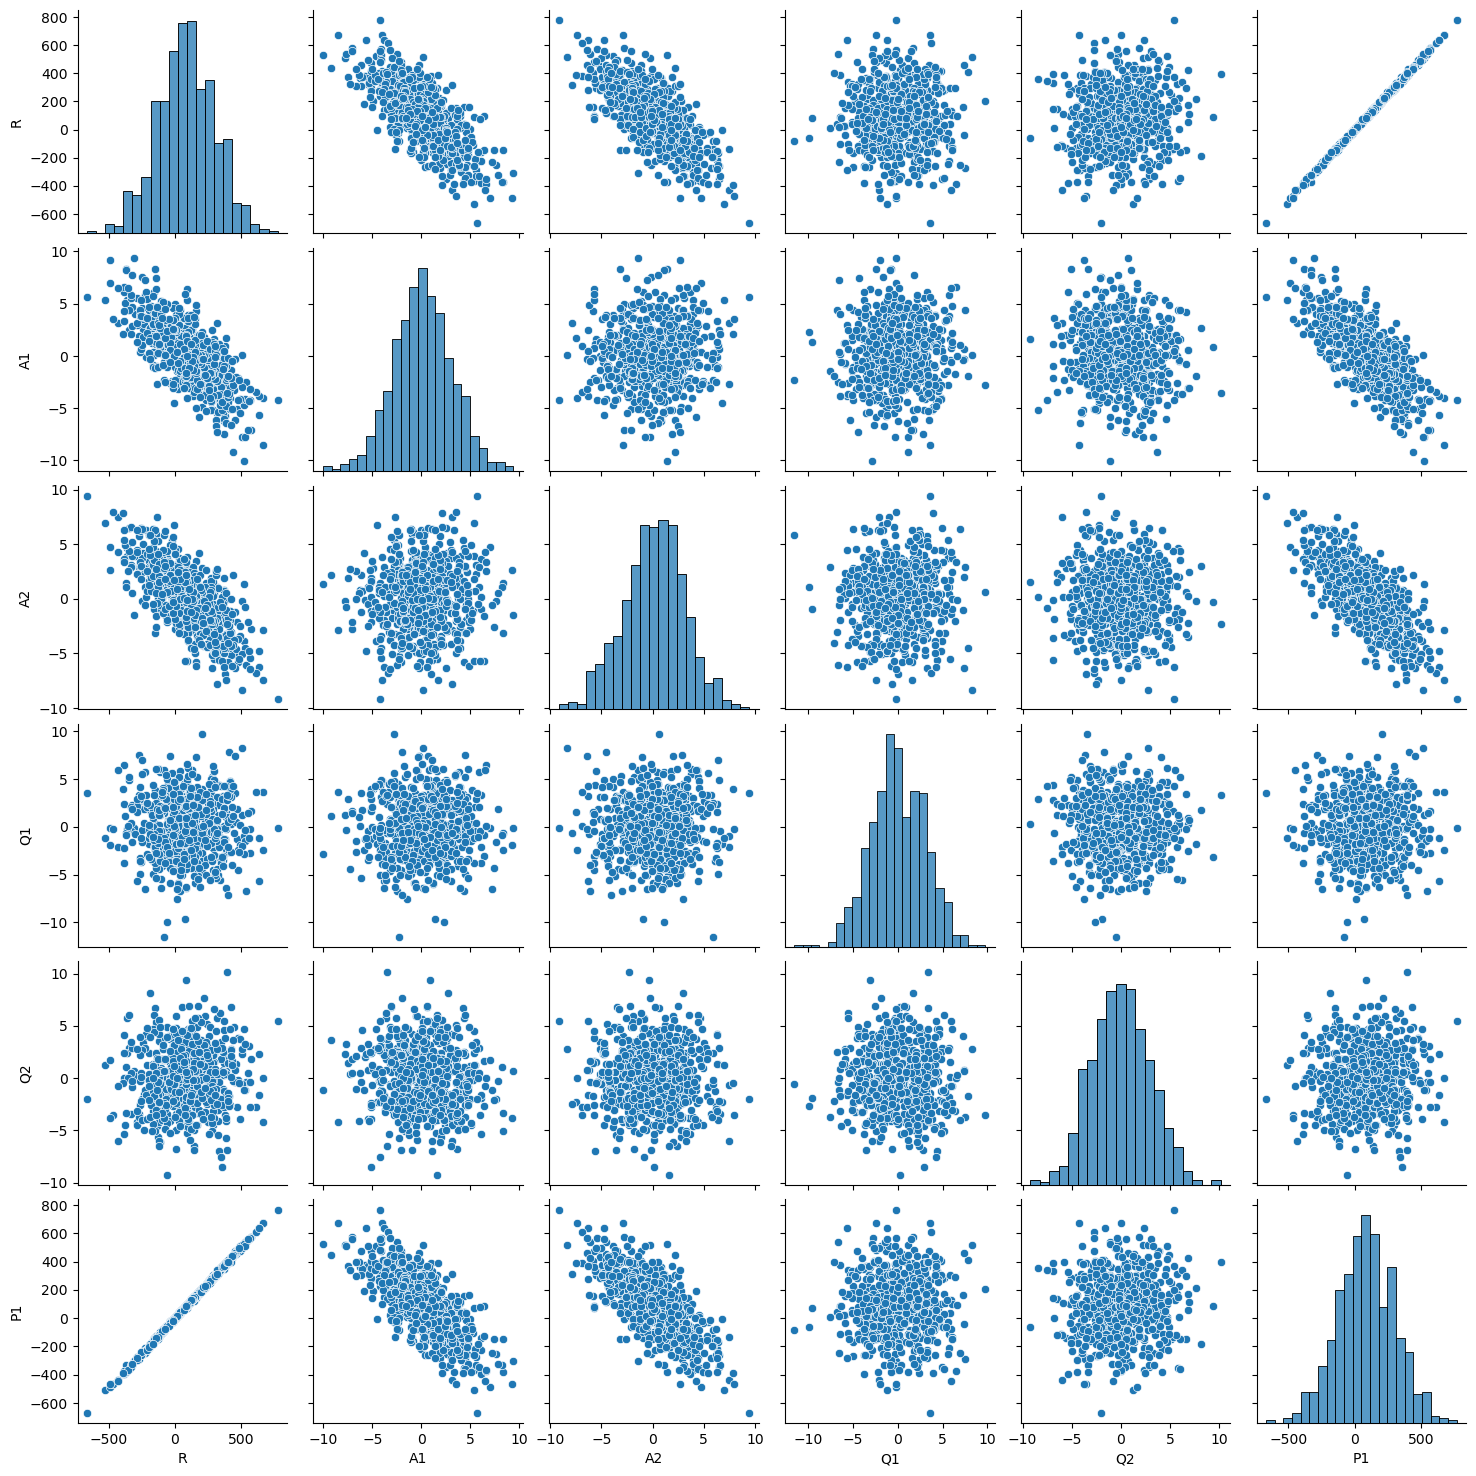

In [47]:
sns.pairplot(X_train)
plt.show()

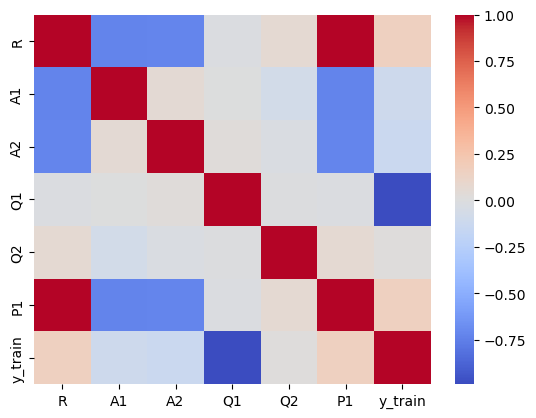

In [48]:
X_train['y_train'] = y_train
sns.heatmap(X_train.corr(), fmt=".2f", cmap='coolwarm')
plt.show()

## Bias Mitigation and Fairness

## References

**Baumann, Joachim**, **Castelnovo, Alessandro**, **Crupi, Riccardo**, **Inverardi, Nicole**, and **Regoli, Daniele**. 2023. **Bias on Demand: A Modelling Framework That Generates Synthetic Data With Bias**. *In Proceedings of the 2023 ACM Conference on Fairness, Accountability, and Transparency*. [https://doi.org/10.1145/3593013.3594058](https://doi.org/10.1145/3593013.3594058).
